In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd

import nilearn
from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img
from nilearn import surface
from nilearn.glm.contrasts import compute_contrast

# Let us use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

C:\ProgramData\Anaconda3\lib\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
# Set variables
root_data="C:\\Users\\bdireito\\Data\\BIDS"
sub="sub-0001"
ses="ses-001"

file_sep="\\"
data_path=root_data + file_sep + sub + file_sep + ses

print(data_path)

root_project="C:\\Users\\bdireito\\Documents\\GitHub\\MVPA-speech_project\\"


C:\Users\bdireito\Data\BIDS\sub-0001\ses-001


In [4]:
os.getcwd()

'C:\\Users\\bdireito\\Documents\\GitHub\\MVPA-speech_project\\MVPA-project-admin'

# Structural data.

## Check registration using FSL BET (brain extraction) + FEAT

C:\ProgramData\Anaconda3\lib\site-packages\nilearn\image\resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


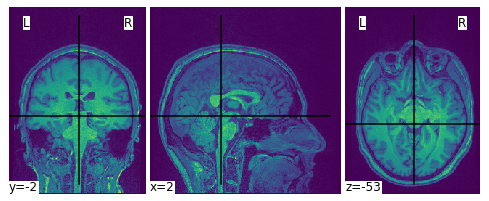

In [5]:
t1w_file_path=data_path + "\\anat\\sub-0001_ses-001_run-01_T1w.nii.gz"
plotting.plot_img(t1w_file_path)

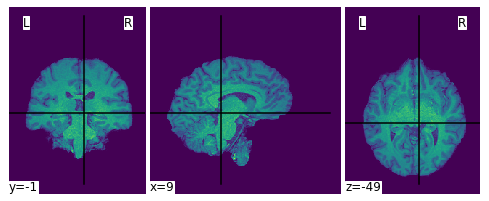

In [6]:
t1w_brain_file_path=data_path + "\\anat\\sub-0001_ses-001_run-01_T1w_brain.nii.gz"

plotting.plot_img(t1w_brain_file_path)

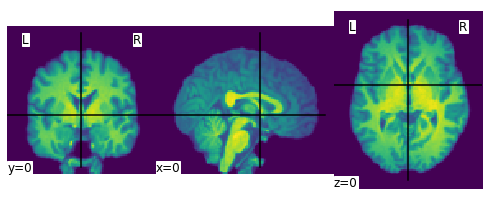

In [7]:
t1w_prepro_file_path=data_path + "\\run-1.feat\\reg\\highres2standard.nii.gz"

cut_coords=(0, 0, 0)
plotting.plot_img(t1w_prepro_file_path, cut_coords)

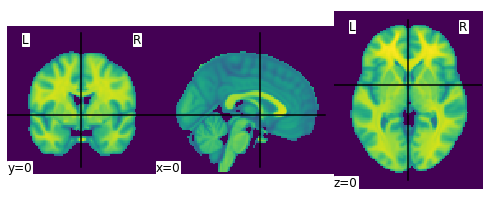

In [8]:
plotting.plot_img(datasets.MNI152_FILE_PATH, cut_coords)

# Functional data.
## Check preprocessing using FSL FEAT

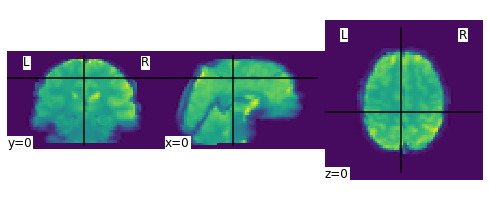

In [9]:
func_data_preproc=data_path + "\\run-1.feat\\filtered_func_data.nii.gz"

mean_fmri_img=mean_img(func_data_preproc)
plotting.plot_img(mean_fmri_img, cut_coords)

(91, 109, 91)


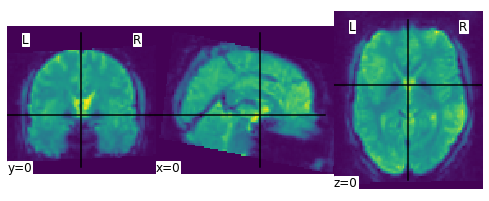

In [10]:
func_data_preproc_2high=data_path + "\\run-1.feat\\reg\\example_func2standard.nii.gz"

mean_fmri_img_2high=mean_img(func_data_preproc_2high)

print(image.load_img(func_data_preproc_2high).shape)

plotting.plot_img(mean_fmri_img_2high, cut_coords)

(91, 109, 91, 222)


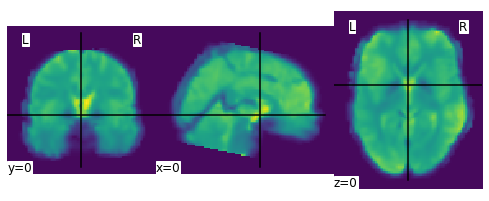

In [11]:
func_data_preproc_2standard=data_path + "\\run-1.feat\\filtered_func_data2standard.nii.gz"

mean_fmri_img_2standard=mean_img(func_data_preproc_2standard)

print(image.load_img(func_data_preproc_2standard).shape)

plotting.plot_img(mean_fmri_img_2standard, cut_coords)


## Look at the events and design matrix.

In [12]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 2.5  # repetition time is ? second
n_scans = 222  # the acquisition comprises ?? scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# load events.tsv
events_PATH=root_project+"\\convert-bids-admin\\DOCKER\\events.tsv"

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")
print(events_df.head())



  trial_type  onset  duration
0  Baseline     0.0      12.5
1      Task    15.0      27.5
2  Baseline    45.0      12.5
3      Task    60.0      27.5
4  Baseline    90.0      12.5


<AxesSubplot:label='conditions', ylabel='scan number'>

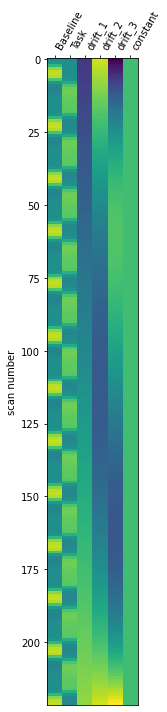

In [13]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

plot_design_matrix(design_matrix)

**Statistical analysis - 1st level**

In [14]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
basic_contrasts['+Task-Baseline'] = (
    basic_contrasts['Task ']
    - basic_contrasts['Baseline '])


In [15]:
basic_contrasts

{'Baseline ': array([1., 0., 0., 0., 0., 0.]),
 'Task ': array([0., 1., 0., 0., 0., 0.]),
 'drift_1': array([0., 0., 1., 0., 0., 0.]),
 'drift_2': array([0., 0., 0., 1., 0., 0.]),
 'drift_3': array([0., 0., 0., 0., 1., 0.]),
 'constant': array([0., 0., 0., 0., 0., 1.]),
 '+Task-Baseline': array([-1.,  1.,  0.,  0.,  0.,  0.])}

In [18]:
from nilearn.glm.first_level import FirstLevelModel

fmri_img=data_path + "\\run-1.feat\\filtered_func_data2standard.nii.gz"

print('Fitting a GLM')
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix)

Fitting a GLM


In [20]:
mean_image = mean_img(fmri_img)
z_map = fmri_glm.compute_contrast(basic_contrasts['+Task-Baseline'], output_type='z_score')

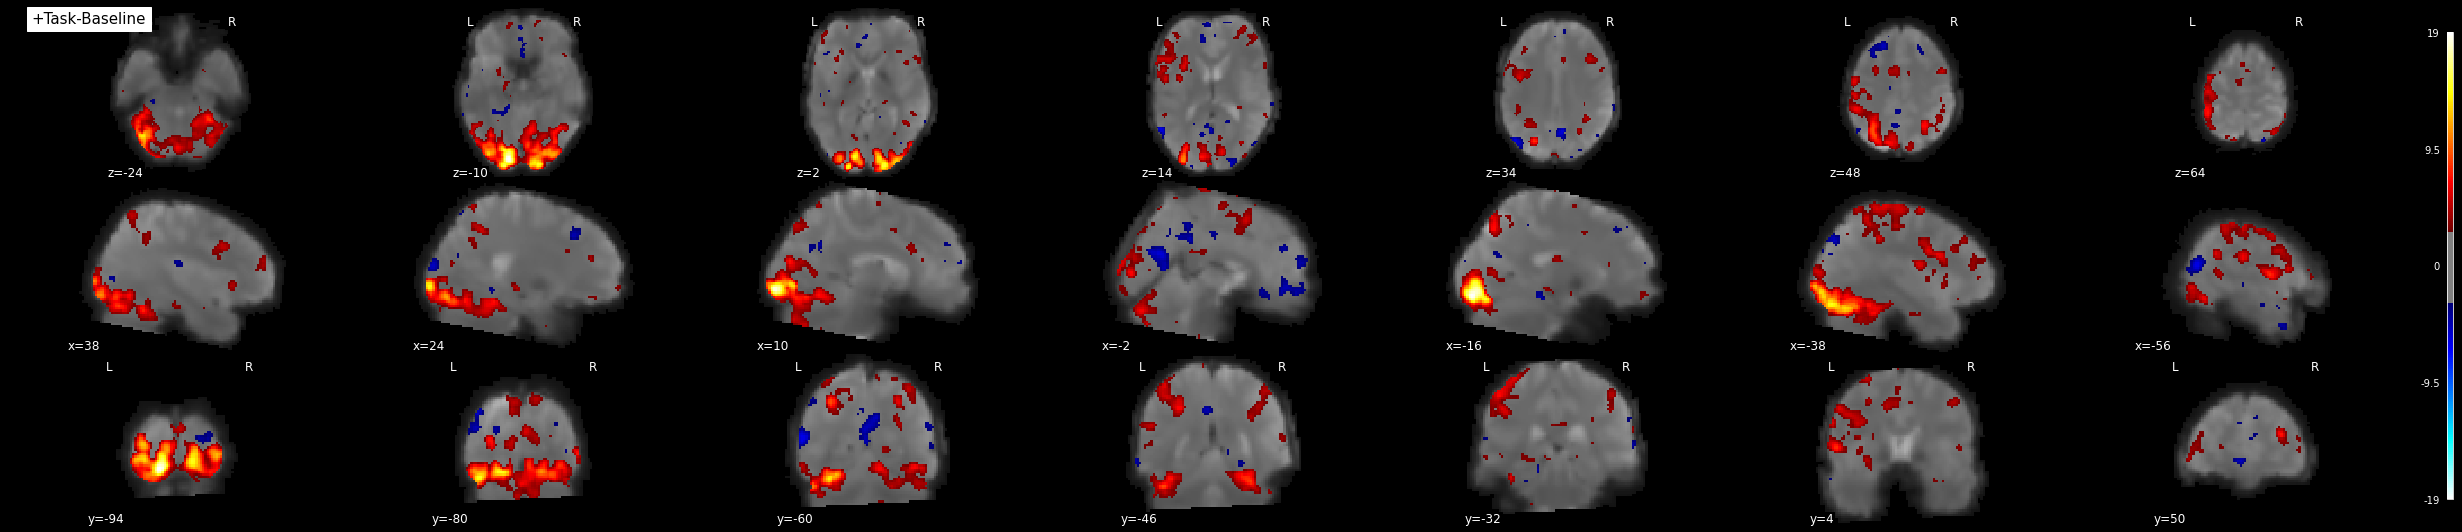

In [21]:
# plot the contrasts 
# the display is overlayed on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
plotting.plot_stat_map(
    z_map, bg_img=mean_image, threshold=3, display_mode='mosaic', black_bg=True, title='+Task-Baseline')
plotting.show()


# Project map in surface.

fsaverage5 template from the FreeSurfer software.

In [22]:
fsaverage = nilearn.datasets.fetch_surf_fsaverage()

The projection function simply takes the fMRI data and the mesh. Note that those correspond spatially, are they are both in MNI space.

In [23]:
from nilearn.glm.first_level import run_glm

texture = surface.vol_to_surf(fmri_img, fsaverage.pial_right)

labels, estimates = run_glm(texture.T, design_matrix.values)

contrast =compute_contrast(labels, estimates, basic_contrasts['+Task-Baseline'], contrast_type='t')


In [24]:
# we present the Z-transform of the t map
z_map = contrast.z_score()
z_map.shape


(10242,)

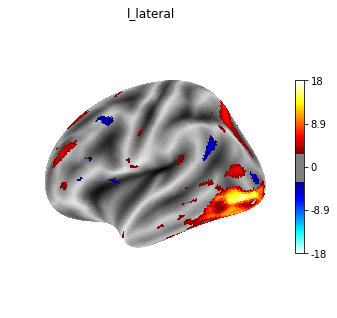

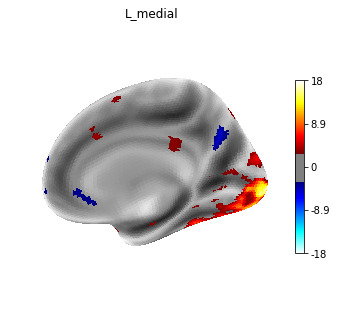

In [25]:
# we plot it on the surface, on the inflated fsaverage mesh,
# together with a suitable background to give an impression
# of the cortex folding.
plotting.plot_surf_stat_map(fsaverage.infl_left, z_map,
                            hemi='left',title='l_lateral',
                            colorbar=True,threshold=3.,
                            bg_map=fsaverage.sulc_left)

plotting.plot_surf_stat_map(fsaverage.infl_right, z_map,
                            hemi='left',title='L_medial',
                            colorbar=True,threshold=3.,
                            bg_map=fsaverage.sulc_right)

plotting.show()

# Decoding 

## A first estimator.
http://nilearn.github.io/decoding/decoding_intro.html#performing-a-simple-decoding-analysis


In [26]:
# brain_mask = datasets.load_mni152_brain_mask()

from nilearn.datasets import fetch_icbm152_brain_gm_mask
brain_mask = fetch_icbm152_brain_gm_mask()

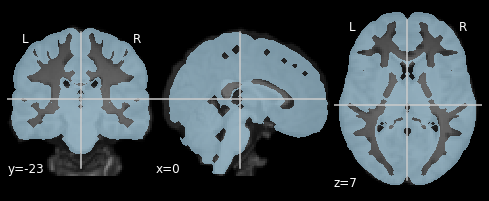

In [27]:
plotting.plot_roi(brain_mask, bg_img=t1w_prepro_file_path,
                  cmap='Paired')

In [28]:
from nilearn.decoding import Decoder 

decoder = Decoder(estimator='svc', mask=brain_mask) 

Load the behavioral data. 

define the labels (classes) and the corresponding data.

In [29]:
fmri_niiimgs=image.load_img(func_data_preproc_2standard)
fmri_niiimgs.shape

(91, 109, 91, 222)

In [30]:
idxs=events_df['onset']/tr
conditions = []

for i in range(len(events_df)):
    idx_2=((events_df['duration'][i]/tr))+1
    for j in range(int(idx_2)):
        conditions.append(events_df['trial_type'][i])

In [31]:
from nilearn.image import index_img
trainset = index_img(fmri_niiimgs, slice(0, -50))
trainset.shape

(91, 109, 91, 172)

In [32]:
decoder.fit(trainset, conditions[:-50]) 



In [33]:
testset = index_img(fmri_niiimgs, slice(-50,None))
testset.shape

(91, 109, 91, 50)

In [34]:
prediction=decoder.predict(testset)
print((prediction == conditions[-50:]).sum() / float(len(conditions[-50:])))

0.92



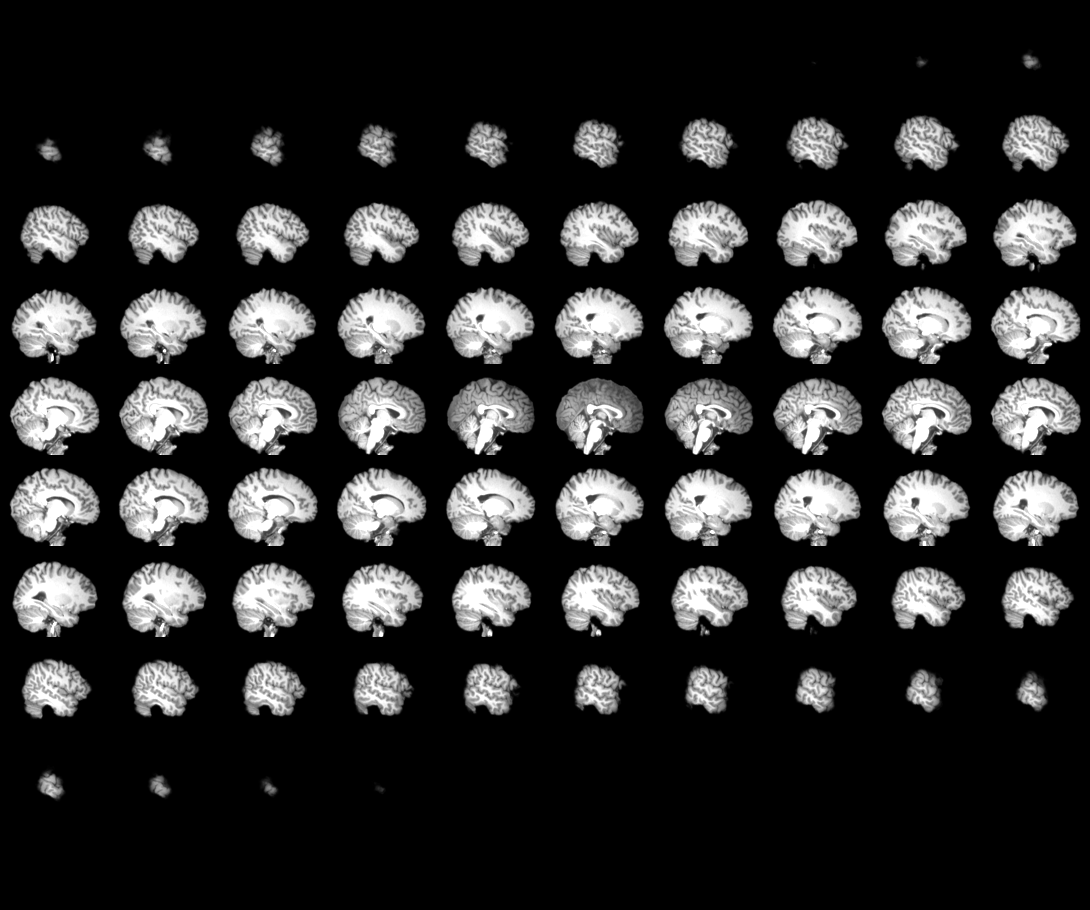
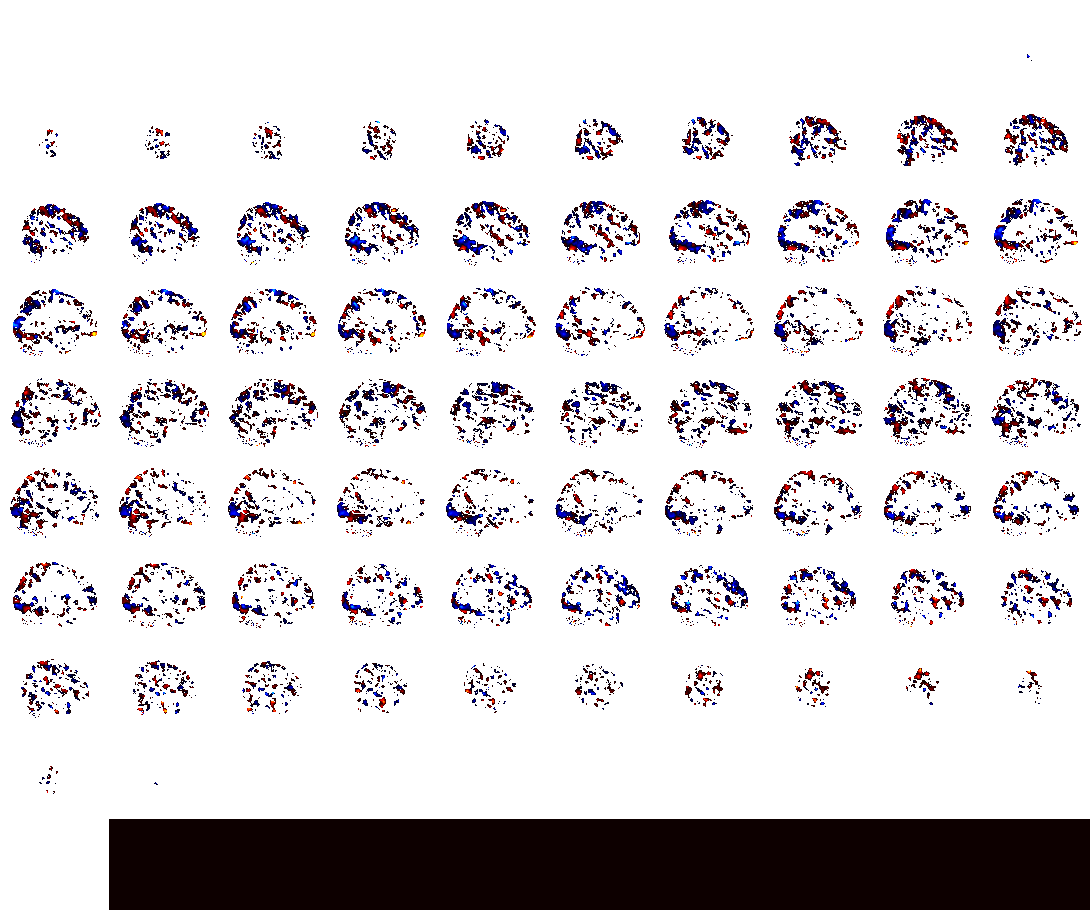

In [35]:
plotting.view_img(
    decoder.coef_img_['Task '], bg_img=t1w_prepro_file_path,
    title="SVM weights", dim=-1
)

In [ ]:
plotting.view_img(
    decoder.coef_img_['Baseline '], bg_img=t1w_prepro_file_path,
    title="SVM weights", dim=-1
)

In [40]:
from joblib import dump, load


dump(decoder, 'filename.joblib') 

['filename.joblib']